### import packages

In [15]:
import numpy as np
import subprocess
from pathlib import Path
import os
import open3d as o3d
import vedo
import shutil
import json
import importlib
import sys
from PIL import Image
import copy

### Set Output Path

In [16]:
output_path = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\meshroom_data\moving_ms_20_3cam"

### loading reconstructed data

In [17]:
# Define the evaluation_path by combining the output_path and "Evaluation" directory
evaluation_path = Path(output_path) / "Evaluation"
# Initialize an empty dictionary to store the read variables
variables = {}
# Open the cache.txt file located in the evaluation_path directory in read mode
with open((evaluation_path / "cache.txt"), 'r') as cache_file:
    # Iterate through each line in the file
    for line in cache_file:
        # Split each line by the colon ':' to separate variable name and value
        name, value = line.strip().split(":", 1)
        # Add the variable name and value pair to the variables dictionary after stripping whitespace
        variables[name.strip()] = value.strip()
# Access the read variables from the dictionary
project_name = variables.get("project_name", "")
output_path = variables.get("output_path", "")
image_dir = variables.get("image_dir", "")
obj_path = variables.get("obj_path", "")
# Print out the read variables
print("Read Variables:")
print("Project Name:", project_name)
print("Output Path:", output_path)
print("Image Directory:", image_dir)
print("OBJ Path:", obj_path)

Read Variables:
Project Name: moving_ms_20_3cam
Output Path: c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\meshroom_data\moving_ms_20_3cam
Image Directory: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_data\moving_ms_20_3cam
OBJ Path: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\MS_20_2\centered\MS_22_2_wR_schw_M.obj


#### plot reconstructed mesh

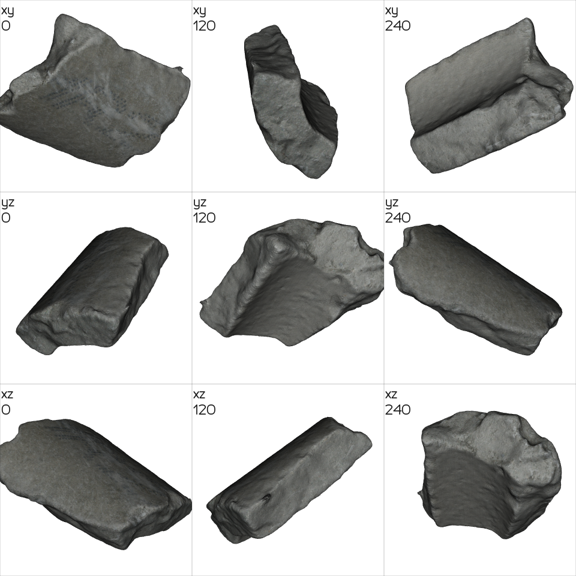

In [18]:
importlib.reload(sys.modules['src.plot_mesh_vedo']) if 'src.plot_mesh_vedo' in sys.modules else None
from src.plot_mesh_vedo import plot_mesh_vedo
fig,screenshot_path = plot_mesh_vedo(project_name,evaluation_path)
img = Image.open(screenshot_path)
scale = 0.6
display(img.resize(( int(img.width * scale), int(img.height * scale))))

#### Scaling factor

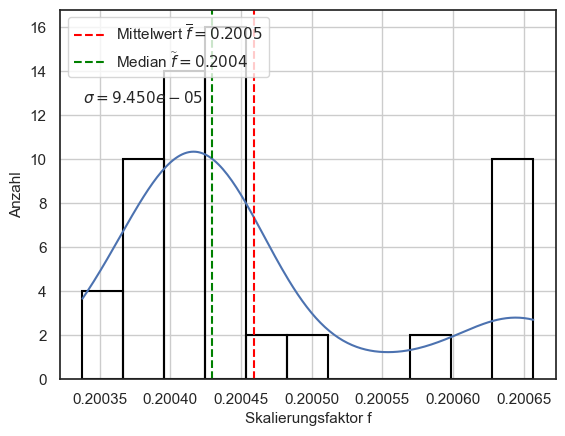

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
importlib.reload(sys.modules['src.scaling_factor']) if 'src.scaling_factor' in sys.modules else None
from src.scaling_factor import scaling_factor
factor_mean, factor_median, factor_std, cam_pos_rec, cam_pos_blender, fig = scaling_factor(output_path,image_dir,evaluation_path) # approximate scaling factor 

scaling = factor_median             # Set the scaling factor
T_scale = np.eye(4)                 # Initialize a 4x4 identity matrix for the transformation matrix
for i in range(3):                  # Iterate over the first 3 diagonal elements of the matrix and set them to the scaling factor
    T_scale[i,i] = scaling

### Alignment of the reconstructed mesh with the ground truth

In [20]:
# Define file path to the mesh files
mesh_gt_path = obj_path                                                   # Path to ground truth mesh
mesh_r_path = evaluation_path / 'texturedMesh.obj'                        # Path to reconstructed mesh

#### Global Registration using open3d / Feature based alignment

In [21]:
AutomatedGlobalRegistration = True
importlib.reload(sys.modules['src.GlobalMeshRegistration']) if 'src.GlobalMeshRegistration' in sys.modules else None
from src.GlobalMeshRegistration import GlobalMeshRegistration
voxel_size = 1*10**(-3)
draw_registration = 4 # choose 0,1,2,3,4 --> 0 = no plot appears --> 4 = all plots appears 
T_global = GlobalMeshRegistration(mesh_r_path,mesh_gt_path,voxel_size,draw_registration,T_scale,AutomatedGlobalRegistration)

T_global_path = evaluation_path / 'GlobalTransformationMatrix.txt'    # Define the file path for the saved transformation matrix
np.savetxt(T_global_path,T_global)

# OUTDATED
#else: #Do It manually 
#    T_global_path = evaluation_path / 'GlobalTransformationMatrix_manual.txt'    # Define the file path for the saved transformation matrix
#    T_global = np.loadtxt(T_global_path)
    # 1.) open CloudCompare
    # 2.) load texturedMesh (reconstructed) and the ground truth mesh (centered) 
    # 3.) deactivate normals on the ground truth mesh under Properties -> CC Object -> Normals
    # 4.) select both meshes by holding the control button. Important: First, select the ground truth mesh and then the reconstructed mesh 
    # 5.) scale the reconstructed mesh with the calculated scaling factor:
    #       - select the texturedMesh and go to edit -> Multiply/Scale --> enter the scaling factor and press Ok
    # 6.) Rotate the reconstructed Mesh (texturedMesh) with the Translate/Rotate Function in the top bar
    #   a) switch back and forth between the visibility of the objects and memorize distinctive spots on the ground truth mesh
    #   b) select the texturedMesh and use the Translate/Rotate Function
    #   c) rotate the texturedMesh so that the two meshes lie approximately on top of each other 
    # 7.) Finely Register the two Meshes
    #    a) select both meshes, click on the Finely Register Button on the top bar
    #    b) swap the meshes, if texturedMesh is not the "to be aligned"-Mesh
    #    c) click okay (disable adjust scale)
    # 8.) Export the Transformation Matrix
    #   a) select the texturedMesh.registered and export the transformation history under Properties --> Transformation history --> Export --> ASCII   
    #   b) save the File under "/../Evaluation/GlobalTransformationMatrix_manual.txt" 
    # 9.) Save the Registration inside a CloudCompare file 


:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.001,
   we use a liberal distance threshold 0.002.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.961621e-04, and correspondence_set size of 2608
Access transformation to get result.


#### Fine Registration using CloudCompare / Iterative Closest Point (ICP) algorithm

In [22]:
# Set parameters
save_meshes_all_at_once = False                 # Save the transformed reconstructed mesh with the Groud_truth mesh in a single file (uses a lot of hard disk space)
silent = True                                   # No GUI pops up and no clicks necessary
adjust_scale = True                            # Alignment of the Mesh with SCALING
# Define output format for meshes
output_format_mesh = "OBJ"                                              # Format can be one of the following: BIN, OBJ, PLY, STL, VTK, MA, FBX.

# Function to align the reconstruected mesh and to calculate the Mesh to Mesh distance
importlib.reload(sys.modules['src.FineMeshRegistration_and_MeshToMeshDistance']) if 'src.FineMeshRegistration_and_MeshToMeshDistance' in sys.modules else None
from src.FineMeshRegistration_and_MeshToMeshDistance import FineMeshRegistration_and_MeshToMeshDistance
params_CC = [silent,save_meshes_all_at_once,adjust_scale,output_format_mesh]
T,T_ICP,mesh_r_trans_path,log_path = FineMeshRegistration_and_MeshToMeshDistance(params_CC,evaluation_path,mesh_gt_path,mesh_r_path,output_format_mesh,T_global_path)

In [23]:
matrix = T_ICP
s_x = np.linalg.norm(matrix[:, 0])  # Length of the first column vector
s_y = np.linalg.norm(matrix[:, 1])  # Length of the second column vector
s_z = np.linalg.norm(matrix[:, 2])  # Length of the third column vector

print("Scaling in X direction:", s_x)
print("Scaling in Y direction:", s_y)
print("Scaling in Z direction:", s_z)
print("Scaling factor:", scaling)
print("Scaling factor by CC:", scaling*np.mean([s_x,s_y,s_z]))

Scaling in X direction: 1.0011141469995108
Scaling in Y direction: 1.00111414728343
Scaling in Z direction: 1.0011141952984641
Scaling factor: 0.20042927522957876
Scaling factor by CC: 0.2006525861509999


### Cloud to Mesh: Mean Distance and Standard Deviation

In [24]:
# Reload the module 'read_c2m_distance_from_log' if it's already imported
importlib.reload(sys.modules['src.read_c2m_distance_from_log']) if 'src.read_c2m_distance_from_log' in sys.modules else None
from src.read_c2m_distance_from_log import read_c2m_distance_from_log
# Call the function to read mean distance and standard deviation from the log file
mean_distance, std_deviation = read_c2m_distance_from_log(log_path)

Cloud to Mesh Distance:
----------------------------------------
Global Mesh Registration
Mean distance: -1.01054e-05, Standard deviation: 9.36251e-05
--------------------
Closest Point Registration Procedure (ICP)
Mean distance: -2.83458e-06, Standard deviation: 4.78697e-05


### Comparison of volumes and surfaces

In [25]:
importlib.reload(sys.modules['src.EvaluateVolumeSurfaceArea']) if 'src.EvaluateVolumeSurfaceArea' in sys.modules else None
from src.EvaluateVolumeSurfaceArea import EvaluateVolumeSurfaceArea
EvaluateVolumeSurfaceArea(evaluation_path,mesh_gt_path,T_global,T)

Object                                          Volume (m^3)    Surface Area (m^2)    Sauter Diameter (mm)
--------------------------------------------  --------------  --------------------  ----------------------
Reconstructed Obj.                               5.21408e-06            0.00206316                 15.1634
Reconstructed Obj. (Scaling by CloudCompare)     5.23153e-06            0.00206776                 15.1803
Ground Truth                                     5.24071e-06            0.00218013                 14.4231


### Plot Cameras

#### real cameras

In [36]:
importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer

# define parameters
focal_length = 16*10**(-3)
sensor_width = 7.12*10**(-3)
aspect_ratio = 7.12/5.33
scale = 2

# visualize cameras
visualizer = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])
visualizer.load_cameras_blender(cam_pos_blender,focal_length,aspect_ratio,sensor_width,scale)
# dynamic case    
if cam_pos_blender.iloc[-1]["TimeStep"] != 1:      
    visualizer.create_cube(position=[0,0,1.2],size=0.03,color='k',alpha=0.4,rotation=[15,0,15])   # size=a=b=c
    visualizer.create_cube(position=[0,0,1.05],size=0.03,color='k',alpha=0.3,rotation=[30,0,30])
    visualizer.create_cube(position=[0,0,0.95],size=0.03,color='k',alpha=0.2,rotation=[45,0,45])
    visualizer.create_cube(position=[0,0,0.8],size=0.03,color='k',alpha=0.1,rotation=[60,0,-60])
# static case    
else:
    visualizer.create_cube(position=[0,0,0],size=0.03,color='k',alpha=0.3)
#%matplotlib inline        
%matplotlib qt 
title = 'Extrinsic Camera Parameter (Ground Truth)'
visualizer.show(title)
path = evaluation_path / "Extrinsics_Cams_GT"
visualizer.save(path)

c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\src\camera_pose_visualizer.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.title(title)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


initialize camera pose visualizer


#### reconstructed cameras